### Hiring Decisions
Il dataset (preso e modificato da kaggle) si trova al link https://bit.ly/4ckMxMd e contiene dati relativi ad alcuni candidati da 
assumere in un’azienda. Si vuole predire se un candidato verrà assunto (HiringDecision).


1. Quante sono le istanze contenute nel dataset? Il dataset è completo (cioè per ogni istanza sono sempre specificati <br/>
tutti i valori di ogni attributo)? Il dataset è bilanciato rispetto alla classe da predire?

In [1]:
import pandas as pd

df = pd.read_csv('dataset.csv', sep=',')

n_instances = df.index.size
completness = df.notna().all().all()
count_s = df.groupby('HiringDecision')['id'].count()

print(f"istanze: {n_instances}\ncompleto: {completness}\nbilanciato? (no):\n{count_s}")

istanze: 1500
completo: True
bilanciato? (no):
HiringDecision
0    1035
1     465
Name: id, dtype: int64


2. Caricare il dataset, eliminare eventuali attributi inutili (motivare la scelta), eliminare eventuali istanze con valori nulli, <br/>
dividere il dataset in train (75%) e test (25%), preservando le proporzioni delle classi del target.

In [2]:
df.head()

,id,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,0,26,1,2,0,3,26.783828,48,78,91,1,1
1,1,39,1,4,12,3,25.862694,35,68,80,2,1
2,2,48,0,2,3,2,9.920805,20,67,13,2,0
3,3,34,1,2,5,2,6.407751,36,27,70,3,0
4,4,30,0,1,6,1,43.105343,23,52,85,2,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['HiringDecision'])
y = df['HiringDecision']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

3. Valutare le performance sia sul dataset train sia sul dataset test del modello SGDClassifier, tenendo in considerazione <br/>
F1-score e la confusion matrix.


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

model = SGDClassifier()

std_cols = [c for c in X_train.columns if c != 'Gender']

coltran = ColumnTransformer(transformers=[
    ('stdscaler', StandardScaler(), std_cols)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessing', coltran),
    ('model', model)
])

pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('stdscaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

accuracy: 0.816
f1 score: 0.7063829787234043


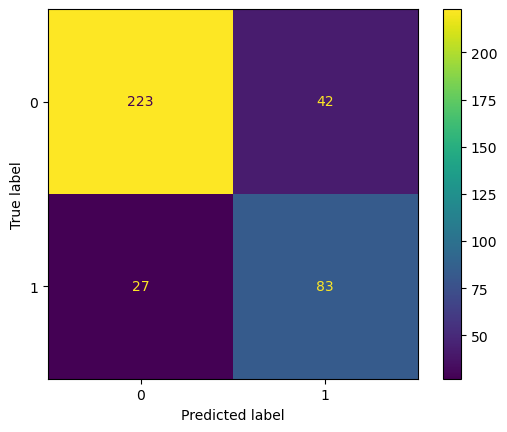

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score

y_predicted = pipeline.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_predicted)
f1 = f1_score(y_true=y_test, y_pred=y_predicted)
print(f"accuracy: {accuracy}\nf1 score: {f1}")
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)

4. Analisi della fairness del modello: valutare, con i dati del test set e rispetto al modello SGDClassifier, se la probabilità <br/>
di predire 0 è la stessa per uomini (0) e donne (1). Il modello ha le stesse performance sul dataset degli uomini e sul <br/>
dataset delle donne? Calcolando la metrica demographic_parity_ratio della libreria fairlearn, è possibile stabilire che il <br/>
modello rispetta la “parità demografica”? Eliminare l’attributo Gender e valutare se le performance del modello ottenute <br/>
negli uomini sono le stesse ottenute nelle donne.

In [6]:
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_ratio

mf = MetricFrame(
    metrics= {'accuracy': accuracy_score, 'f1_score': f1_score, 'selection_rate': selection_rate}, 
    y_true=y_test,
    y_pred=y_predicted,
    sensitive_features=X_test['Gender']
)

pred_0_men = 1 - mf.by_group.loc[0, 'selection_rate']
pred_0_women = 1 - mf.by_group.loc[1, 'selection_rate']

print(f"\nProbabilità di predire 0 (Uomini): {pred_0_men:.2f}")
print(f"Probabilità di predire 0 (Donne): {pred_0_women:.2f}")


Probabilità di predire 0 (Uomini): 0.67
Probabilità di predire 0 (Donne): 0.67


In [7]:
demo_ratio = demographic_parity_ratio(
    y_true=y_test,
    y_pred=y_predicted,
    sensitive_features=X_test['Gender']
)

print(f"Demographic Parity Ratio: {demo_ratio:.4f}")


Demographic Parity Ratio: 1.0000


In [ ]:
X_train_unaware = X_train.drop(columns=['Gender'])
X_test_unaware = X_test.drop(columns=['Gender'])

cols_unaware = list(X_train_unaware.columns)

pipeline_unaware = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('scaler', StandardScaler(), cols_unaware)
    ])), 
    ('classifier', SGDClassifier(random_state=42))
])

pipeline_unaware.fit(X_train_unaware, y_train)

y_pred_unaware = pipeline_unaware.predict(X_test_unaware)

mf_unaware = MetricFrame(
    metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred_unaware,
    sensitive_features=X_test['Gender']
)

print("\n--- Risultati SENZA attributo Gender ---")
print(mf_unaware.by_group)

# Calcoliamo il nuovo ratio
new_demo_ratio = demographic_parity_ratio(y_test, y_pred_unaware, sensitive_features=X_test['Gender'])
print(f"Nuovo Demographic Parity Ratio: {new_demo_ratio:.4f}")


--- Risultati SENZA attributo Gender ---
        accuracy  selection_rate
Gender                          
0       0.751323        0.264550
1       0.854839        0.290323
Nuovo Demographic Parity Ratio: 0.9112


5. Analisi della feature importance: applicare la tecnica Permutation Feature Importance (PFI) considerando il modello <br/>
SGDClassifier per trovare le feature più importanti. Per garantire una certa stabilità dei risultati, applicare 10 <br/>
permutazioni diverse ad ogni feature. Visualizzare attraverso un boxplot per ogni feature le differenze di F1-score in ogni <br/> 
permutazione.

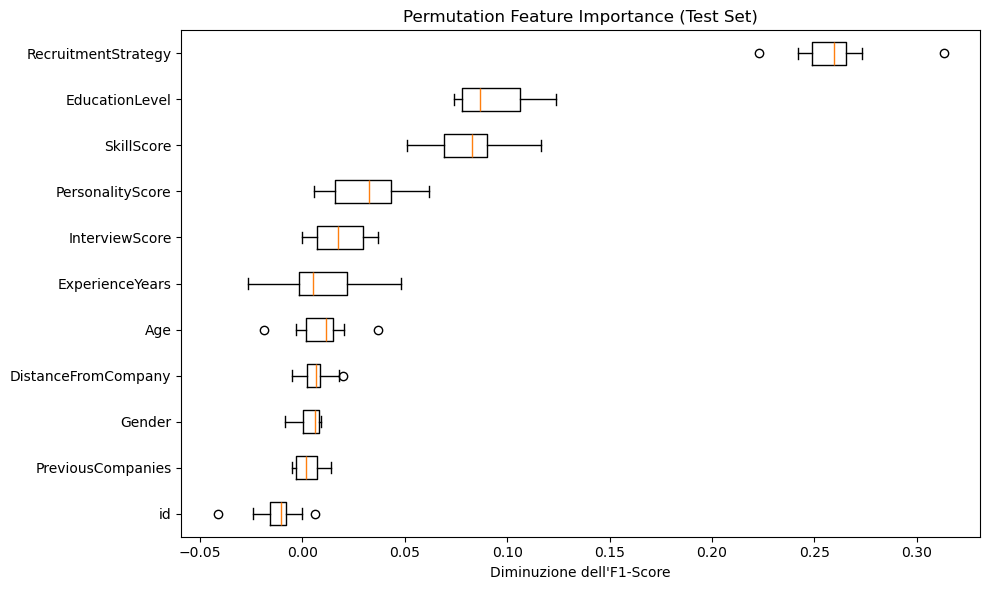

In [22]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Calcoliamo l'importanza
# Nota: passiamo la PIPELINE, non il modello grezzo
r = permutation_importance(pipeline, X_test, y_test,
                           n_repeats=10,
                           random_state=42,
                           scoring='f1') # Usiamo f1 come richiesto

# 2. Ordiniamo i risultati per visualizzarli meglio
sorted_idx = r.importances_mean.argsort()

# 3. Creiamo il Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(r.importances[sorted_idx].T,
            vert=False,
            tick_labels=X_test.columns[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Diminuzione dell'F1-Score")
plt.tight_layout()
plt.show()

6. Analisi della feature importance: verificare se i risultati ottenuti al punto precedente sono confermati dalla tecnica <br/>
Leave-One-Covariate-Out (ovvero escludo una feature alla volta e vedo come variano le performance del modello). <br/>
Prima delle predizioni, trasformare tutte le feature del dataset tranne Gender usando lo StandardScaler (puoi usare il <br/> 
ColumnTransformer).

In [48]:
import seaborn as sns 

f1_baseline = f1_score(y_test, pipeline.predict(X_test))
print(f"F1-Score Baseline (tutte le feature): {f1_baseline:.4f}\n")

results_loco = {}
feature_list = X_train.columns

for feature_to_drop in feature_list:
    
    X_train_loco = X_train.drop(columns=[feature_to_drop])
    X_test_loco = X_test.drop(columns=[feature_to_drop])
    
    cols_loco = [c for c in X_train_loco.columns if c != 'Gender']
    
    preprocessor_loco = ColumnTransformer(transformers=[
        ('stdscaler', StandardScaler(), cols_loco)
    ], remainder='passthrough')
    
    pipeline_loco = Pipeline(steps=[
        ('preprocessing', preprocessor_loco),
        ('model', SGDClassifier(random_state=42))
    ])
    
    pipeline_loco.fit(X_train_loco, y_train)
    
    y_pred_loco = pipeline_loco.predict(X_test_loco)
    f1_loco = f1_score(y_test, y_pred_loco)
    
    diff = f1_baseline - f1_loco
    results_loco[feature_to_drop] = diff
    print(f"Senza '{feature_to_drop}': F1={f1_loco:.4f} (Delta: {diff:.4f})")


F1-Score Baseline (tutte le feature): 0.7064

Senza 'id': F1=0.7091 (Delta: -0.0027)
Senza 'Age': F1=0.7257 (Delta: -0.0194)
Senza 'Gender': F1=0.6542 (Delta: 0.0522)
Senza 'EducationLevel': F1=0.6346 (Delta: 0.0718)
Senza 'ExperienceYears': F1=0.6904 (Delta: 0.0160)
Senza 'PreviousCompanies': F1=0.6244 (Delta: 0.0819)
Senza 'DistanceFromCompany': F1=0.6544 (Delta: 0.0520)
Senza 'InterviewScore': F1=0.3721 (Delta: 0.3343)
Senza 'SkillScore': F1=0.6316 (Delta: 0.0748)
Senza 'PersonalityScore': F1=0.6789 (Delta: 0.0275)
Senza 'RecruitmentStrategy': F1=0.3354 (Delta: 0.3710)


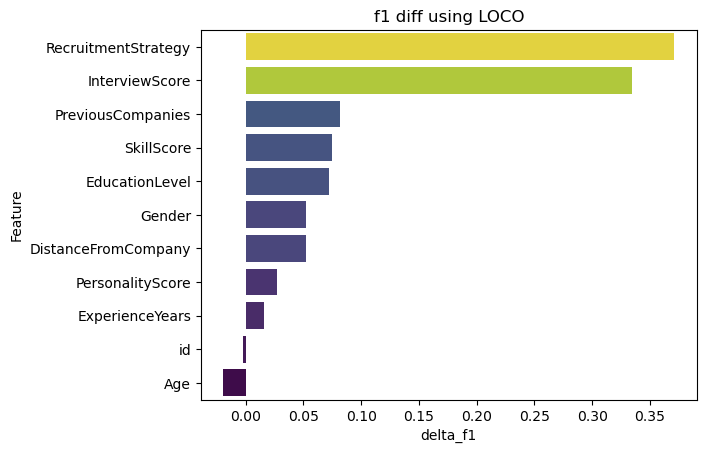

In [51]:
loco_df = pd.DataFrame(results_loco.items(), columns=['Feature', 'delta_f1'])
loco_df.head()

plt.title("f1 diff using LOCO")
sns.barplot(data=loco_df.sort_values(by='delta_f1', ascending=False), 
            x='delta_f1',
            y='Feature',
            hue='delta_f1',
            palette='viridis',
            legend=False)
plt.show()